# Multi-Layer Perceptron Inpainting with MNIST

In the [MLP demo](mlp_denoise_synthetic.ipynb), we saw how to use the multi-layer VAMP (ML-VAMP) method for denoising with a prior based on a multi-layer perceptron.  We illustrated the method on synthetic data generated from a random MLP model.  Here we will repeat the experiment with the MNIST data.  Specifically, we consider the problem of estimating an MNIST digit image $x$ from linear measurements $y$ of the form,
$$
      y = Ax,
$$
where $A$ is a sub-sampling operation.  The sub-sampling operation outputs a subset of the pixels in $x$ corresponding to some non-occuluded area. This problem of reconstructing an image $x$ with a portion of the image removed is called *inpainting*. Inpainting requires a prior on the image. In this demo, we will use an MLP generative model for that prior.

## Importing the Package 
We first import the `vampyre` and other packages as in the [sparse linear inverse demo](sparse_lin_inverse.ipynb).

In [1]:
# Add the vampyre path to the system path
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

# Load the other packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

We will also need other packages including `tensorflow`.  

In [2]:
import tensorflow as tf
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle

from tensorflow.examples.tutorials.mnist import input_data

## Loading the MLP model of MNIST

There are several widely-used methods for generating MLP models for complex data.  In this demo, we will simply load the model in the save parameter file.  The model was trained using a so-called variation auto-encoder method by Kigma and Welling.  You can recreate the model yourself by running the program `vae_train.py`. 

In [3]:
# Load the VAE model
if not os.path.exists('param.p'):
    raise Exception("The parameter file, param.p, is not available.  "+
        "Run the program vae_train.py to build the vae model and save the"+
        " parameters")
[Wdec,bdec,Wenc,benc]  = pickle.load(open("param.p","rb"))

print("Model successfully loaded.")

Model successfully loaded.


## Create a Sub-Sampling Transform

In this demo, the measurements $y$ will be a sub-set of the pixels in the image $x$.  Thus, the estimation problem is to recover $x$ from an occluded image.  We set the vectors `Ierase` and `Ikeep` as list of pixels to erase and keep.

In [4]:
npix = 784
nrow = 28
row0 = 10   # First row to erase
row1 = 20   # Last row to erase
Ierase = range(nrow*row0,nrow*row1)
Ikeep = np.setdiff1d(range(npix), Ierase)

We obtain a set of test images, and erase the pixels

In [5]:
# Load MNIST
if not 'mnist' in locals():
    mnist = input_data.read_data_sets('MNIST')

# Batch size to test on
batch_size = 10

# Get the test images and load them into the final layer
xtrue, labels = mnist.test.next_batch(batch_size)
xtrue = xtrue.T

# Erase the pixels
y = xtrue[Ikeep,:]

# Create the erased image
xerase = np.ones((npix,batch_size))*0.5
xerase[Ikeep,:] = y

Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


We will use the following function to plot the images

In [6]:
def plt_digit(x):
    """
    Plots a digit in the MNIST dataset.
    
    :param:`x` is the digit to plot represented as 784 dim vector
    """
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(np.maximum(0,xsq), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

We plot a few examples of the original image and the occuluded image.  The occlusion is shown as the gra

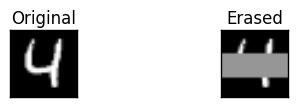

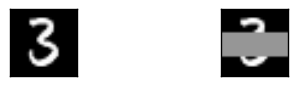

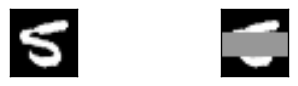

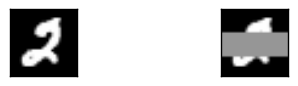

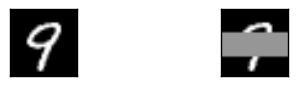

In [7]:
nplot = 5      # number of samples to plot
nrow_plot = 2  # number of images per row
for icol in range(nplot):
    plt.figure(figsize=(5,5))
    plt.subplot(nplot,nrow_plot,icol*nrow_plot+1)
    plt_digit(xtrue[:,icol])
    if (icol == 0):
        plt.title('Original')        
    plt.subplot(nplot,nrow_plot,icol*nrow_plot+2)
    plt_digit(xerase[:,icol])
    if (icol == 0):
        plt.title('Erased')                

## Represent the MLP model for ML-VAMP

We next model the MLP as a multi-layer network for ML-VAMP. One slight complication for the MNIST model is that in the VAE model, the final output stage is modeled as a logistic function which is difficult to capture in ML-VAMP (it does not have a simple analytic denoiser).  So, we replace it with a probit output with the probit variance set to match the logistic variance.

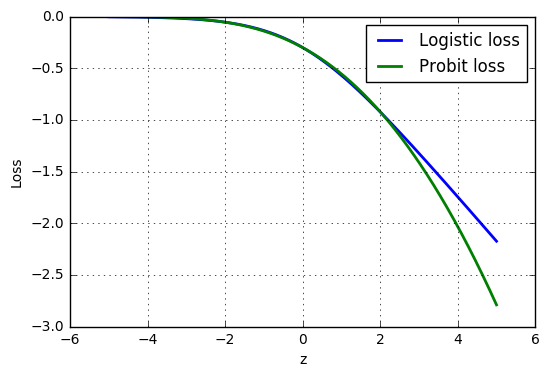

In [8]:
def logistic_var():
    """
    Finds a variance to match probit and logistic regression.
    
    Finds a variance :math:`\\tau_w` such that,
    
        :math:`p=P(W < z) \\approx \\frac{1}{1+e^{-z}},`
        
    where :math:`W \\sim {\\mathcal N}(0,\\tau_w)`.
    """
    z = np.linspace(-5,5,1000)      # z points to test
    p1 = 1/(1+np.exp(-z))           # target probability
    var_test = np.linspace(2,3,1000)
    err = []
    for v in var_test:
        p2 = 0.5*(1+scipy.special.erf(z/np.sqrt(v*2)))
        err.append(np.mean((p1-p2)**2))
    
    i = np.argmin(err)
    wvar = var_test[i]
    return wvar

# Since the logistic loss is not easily modeled in ML-VAMP, we replace
# the logistic loss with an approximate probit loss.  TO this end, we find
# a variance wvar such that the probit and logistic loss match.
wvar = logistic_var()
z = np.linspace(-5,5,1000)
p1 = 1/(1+np.exp(-z))
p2 = 0.5*(1+scipy.special.erf(z/np.sqrt(2*wvar)))

plt.plot(z, np.log10(1-p1), linewidth=2)
plt.plot(z, np.log10(1-p2), linewidth=2)
plt.grid()
plt.xlabel('z')
plt.ylabel('Loss')
plt.legend(['Logistic loss','Probit loss'])


We next create the network to represent the MLP model for ML-VAMP.  This is identical to [MLP demo](mlp_denoise_synthetic.ipynb) where we create one estimator and message handler for each stage.

In [9]:
# Construct the first layer which is a Gaussian prior
batch_size = 10
n0 = Wdec[0].shape[0]
est0 = vp.estim.GaussEst(0,1,shape=(n0,batch_size))
est_list = [est0]

# To improve the robustness, we add damping and place a lower bound on the variance 
damp = 0.75
damp_var = 0.5
alpha_max = 1-1e-3     
rvar_min = 0.01

# Loop over layers in the decoder model
nlayers = len(Wdec)
msg_hdl_list = []
for i in range(nlayers):
    # Get matrices for the layer
    Wi = Wdec[i].T
    bi = bdec[i]
        
    # On the final layer, perform the erasing and add noise
    if (i < nlayers-1):
        wvari = 0
    else:
        Wi = Wi[Ikeep,:]
        bi = bi[Ikeep]
        wvari = wvar            
    
    n1,n0 = Wi.shape
    zshape0 = (n0,batch_size)
    zshape1 = (n1,batch_size)
                
    Wiop = vp.trans.MatrixLT(Wi,zshape0)
    esti = vp.estim.LinEstimTwo(Wiop,bi[:,None],wvari)
    est_list.append(esti)
    
    # Add the nonlinear layer
    if (i < nlayers-1):
        # For all but the last layer, this is a ReLU
        esti = vp.estim.ReLUEstim(zshape1,map_est=False)
    else:
        # For the final layer it is a hard threshold        
        esti = vp.estim.HardThreshEst(y,zshape1)
    est_list.append(esti)

    # Add the message handlers    
    msg_hdl = vp.estim.MsgHdlSimp(shape=zshape0,damp=damp,damp_var=damp_var,\
                                  alpha_max=alpha_max,rvar_min=rvar_min)    
    msg_hdl_list.append(msg_hdl)
    msg_hdl = vp.estim.MsgHdlSimp(shape=zshape1,damp=damp,damp_var=damp_var,\
                                  alpha_max=alpha_max,rvar_min=rvar_min)
    msg_hdl_list.append(msg_hdl)
    
# For further robustness, we limit the variance ratio in layer 1 (the ReLU layer)
msg_hdl_list[1].alpha_max = 0.95

## Reconstruct the MNIST data

We create the VAMP solver and run it.

In [10]:
# Create the MLVamp solver
nit = 50
solver = vp.solver.MLVamp(est_list,msg_hdl_list,comp_cost=True,\
        hist_list=['zhat','zhatvar'],nit=nit)
        
# Run the solver
solver.solve()

Extract the final reconstruction.  We can do this by extracting the estimate for the second last stage `zhat[-2]` and then passing it through the final linear stage.

In [11]:
zhat = solver.zhat

Wi = Wdec[nlayers-1].T
bi = bdec[nlayers-1]
zfinal = Wi.dot(zhat[-2]) + bi[:,None]

xhat = 1/(1+np.exp(-zfinal))

## Plot the Reconstruction

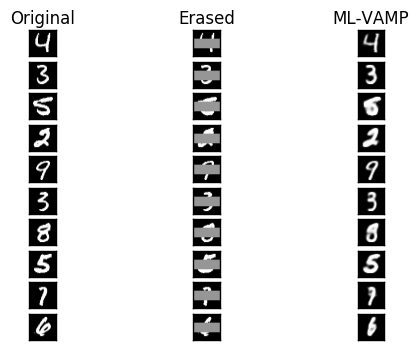

In [12]:
ncol = 10
nrow = 3
for icol in range(ncol):
    plt.subplot(ncol,nrow,icol*nrow+1)
    plt_digit(xtrue[:,icol])
    if (icol == 0):
        plt.title('Original')
    
    plt.subplot(ncol,nrow,icol*nrow+2)
    plt_digit(xerase[:,icol])
    if (icol == 0):
        plt.title('Erased')
    
    plt.subplot(ncol,nrow,icol*nrow+3)
    plt_digit(xhat[:,icol])
    if (icol == 0):
        plt.title('ML-VAMP')
